In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

To Do:

- Download stock data, use the xvy from ACP method with different windows then run all at the same time.
Then do the same comparisons.

In [3]:
def create_hetroskedatic_var_data(length: int, model_error: float = 0.1, var_range: tuple = (0.5, 2)) -> tuple:
        '''Model error = 0.05, means the model is at most 5% wrong in either direction and uniformly between.'''  

        # Exponetial random walk of variances.

        exp_random_walk = np.random.normal(0, 0.1, length)
        true_variance_array = np.exp(np.cumsum(exp_random_walk))

        corresponding_normal = np.random.normal(0, true_variance_array, length)

        # Simulating the model error. 
        model_tolerence = model_error * true_variance_array
        distribution_arround_true = np.random.uniform(-1, 1, length) * model_tolerence
        model_variance_array = true_variance_array + distribution_arround_true

        time_series_normal = np.cumsum(corresponding_normal)

        # Now we need to return as xpred, varpred, y

        return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])

In [9]:
def create_changing_var_data(lookback_array, times) -> tuple:
        '''This will take an array of model errors and return a time series with changing variance models.
        Times will be the number of dists it should make for each model error.
        
        returns dictionary containing the tuples of dists'''  

        # change to lookback
        return_dict = {key: [] for key in lookback_array}

        # Load a random stock
        stock_data = ACP_data.stock_data(times)

        for lookback in lookback_array:
            stock_correction = ACP_data.xvy_from_ACP(stock_data, lookback)
            return_dict[lookback] = stock_correction
            
        return return_dict, stock_data

In [12]:
# Creating the data. 
times = 1
lookback_array = np.linspace(10, 250, 10).astype(int)
model_error_data_dict, aci_data = create_changing_var_data(lookback_array, times)

[ 10  36  63  90 116 143 170 196 223 250]


In [13]:
instance = AdaptiveCP(0.1, 250)
method = AdaptiveCP.HACI_dual_tail
model_error_raw_results = {key: [] for key in lookback_array}

In [14]:
for key in model_error_data_dict:
    print(f'Running model error: {key}')
    for data in model_error_data_dict[key]:
        result = method(instance, data)
        model_error_raw_results[key].append(result)
    print(f'Finished model error: {key}')

#pickling the model_error_raw_results
import pickle
with open(f'vol_window_raw_results{times}.pkl', 'wb') as f:
    pickle.dump(model_error_raw_results, f)


Running model error: 10
Finished model error: 10
Running model error: 36
Finished model error: 36
Running model error: 63


KeyboardInterrupt: 

In [34]:
import pickle
with open(f'vol_window_raw_results{times}.pkl', 'wb') as f:
    pickle.dump(model_error_raw_results, f)

In [32]:
import multiprocessing

incomplete_keys = lookback_array[8:]
print(incomplete_keys)


with multiprocessing.Pool(2) as p:
    result = p.map(instance.HACI_dual_tail, [model_error_data_dict[incomplete_keys[i]][0] for i in range(2)])
    for i in range(2):
        model_error_raw_results[incomplete_keys[i]] = result[i]
    
        

[223 250]


In [4]:
import pickle
model_error_raw_results = pickle.load(open(f'vol_window_raw_results{times}.pkl', 'rb'))

NameError: name 'times' is not defined

## Got results now to Analyse them 
First we will sanatise them.

In [146]:
model_error_raw_results_copy =  model_error_raw_results.copy()
fixed_model_error_raw_results = {key: item[0] if type(item) == list else item for key, item in model_error_raw_results_copy.items()}

a = model_error_raw_results[10]
print(a)
model_error_raw_results[10] = a
model_error_raw_results[36] = model_error_raw_results[36][0]

{'model': 'HACI_dual_tail', 'coverage_target': 0.1, 'gamma': 0.05, 'realised_interval_coverage': 0.8913806451612903, 'alpha_t_list': [0.05, 0.05500000000000001, 0.06000000000000001, 0.06500000000000002, 0.07000000000000002, 0.07500000000000002, 0.08000000000000003, 0.035000000000000024, 0.04000000000000002, 0.045000000000000026, 0.05000000000000003, 0.055000000000000035, 0.06000000000000004, 0.06500000000000004, 0.07000000000000005, 0.07500000000000005, 0.08000000000000006, 0.03500000000000005, 0.04000000000000005, 0.045000000000000054, 0.05000000000000006, 0.05500000000000006, 0.010000000000000057, 0.015000000000000058, 0.02000000000000006, 0.02500000000000006, 0, 0.005000000000000001, 0.010000000000000002, 0.015000000000000003, 0.020000000000000004, 0.025000000000000005, 0.030000000000000006, 0.035, 0.04000000000000001, 0.04500000000000001, 0.05000000000000002, 0.05500000000000002, 0.060000000000000026, 0.06500000000000003, 0.07000000000000003, 0.07500000000000004, 0.0800000000000000

KeyError: 0

In [147]:
for key in model_error_raw_results:
    print(f'Key: {key}, Length: {len(fixed_model_error_raw_results[key])}')

Key: 10, Length: 11
Key: 36, Length: 11
Key: 63, Length: 11
Key: 90, Length: 11
Key: 116, Length: 11
Key: 143, Length: 11
Key: 170, Length: 11
Key: 196, Length: 11
Key: 223, Length: 11
Key: 250, Length: 11


In [148]:
model_error_raw_results[10]

{'model': 'HACI_dual_tail',
 'coverage_target': 0.1,
 'gamma': 0.05,
 'realised_interval_coverage': 0.8913806451612903,
 'alpha_t_list': [0.05,
  0.05500000000000001,
  0.06000000000000001,
  0.06500000000000002,
  0.07000000000000002,
  0.07500000000000002,
  0.08000000000000003,
  0.035000000000000024,
  0.04000000000000002,
  0.045000000000000026,
  0.05000000000000003,
  0.055000000000000035,
  0.06000000000000004,
  0.06500000000000004,
  0.07000000000000005,
  0.07500000000000005,
  0.08000000000000006,
  0.03500000000000005,
  0.04000000000000005,
  0.045000000000000054,
  0.05000000000000006,
  0.05500000000000006,
  0.010000000000000057,
  0.015000000000000058,
  0.02000000000000006,
  0.02500000000000006,
  0,
  0.005000000000000001,
  0.010000000000000002,
  0.015000000000000003,
  0.020000000000000004,
  0.025000000000000005,
  0.030000000000000006,
  0.035,
  0.04000000000000001,
  0.04500000000000001,
  0.05000000000000002,
  0.05500000000000002,
  0.060000000000000026,
 

In [172]:
coverage_results = {}
length_results = {}

for key in model_error_raw_results:
    print(key)
    listy = model_error_raw_results[key]
    
    if type(listy) is dict:
        coverage_results[key] = listy['realised_interval_coverage']
        length_results[key] = listy['average_prediction_interval']
        continue

    coverage_results[key] = listy[0]['realised_interval_coverage']
    length_results[key] = listy[0]['average_prediction_interval']

print(length_results)

10
36
63
90
116
143
170
196
223
250
{10: 5.986622082703028, 36: 6.285459302120264, 63: 6.888181981801004, 90: 6.895553921542294, 116: 9.316296055866712, 143: 8.03155661647393, 170: 10.499299615107313, 196: 10.760540419054282, 223: 12.340168876361961, 250: 12.882908547539744}


In [150]:
err_t = {str(key): pd.Series(result[0]['error_t_list']).rolling(50).mean() for key, result in model_error_raw_results.items()}


KeyError: 0

In [ ]:
data_length = pd.DataFrame.from_dict(length_results, orient='index', columns=['Length'])
reindexed = data_length.reset_index()
print(reindexed)


   index     Length
0     10   5.986622
1     36   6.285459
2     63   6.888182
3     90   6.895554
4    116   9.316296
5    143   8.031557
6    170  10.499300
7    196  10.760540
8    223  12.340169
9    250  12.882909


In [ ]:
print(pd.DataFrame(copy).T)

             10        36        63        90        116       143      170  \
length  5.986622  6.285459  6.888182  6.895554  9.316296  8.031557  10.4993   

             196        223        250  
length  10.76054  12.340169  12.882909  


## Correlation between Interval widths and model_error

In [ ]:
# Testing the correlation between model error and interval length.
temp_data_length = pd.DataFrame.from_dict(length_results, orient='index', columns=['Length'])
data_length = temp_data_length.reset_index()

print(data_length)
print(data_length.corr())

   index     Length
0     10   5.986622
1     36   6.285459
2     63   6.888182
3     90   6.895554
4    116   9.316296
5    143   8.031557
6    170  10.499300
7    196  10.760540
8    223  12.340169
9    250  12.882909
           index    Length
index   1.000000  0.964101
Length  0.964101  1.000000


They are correlated.

## Correlating between coverage and model_error.

In [152]:
## Correlation between interval widths and absolute_error
abs_coverage_differnce = [(key, abs(1 - result['realised_interval_coverage'] - 0.1)) for key, result in model_error_raw_results.items()]
abs_coverage_differnce = pd.DataFrame(abs_coverage_differnce, columns=['Model Error', 'Abs Coverage Difference'])
print(abs_coverage_differnce.corr())

                         Model Error  Abs Coverage Difference
Model Error                 1.000000                 0.780243
Abs Coverage Difference     0.780243                 1.000000


They are not correlated. 
- ACI update is able to kick in, this likley means performs more like aci. 
- if you wernt using the last prediction as your next step then you would likely get worse results, as in the current scenario. Higher variance should directly correlate with a higher score hence it can be modeled well. However may need to pay some thought.

It will be a lot easier if you just fix the raw_results and then you can just proceed.

## Correlation between coverage and variance of the coverage. 

In [154]:
coverage_rolling_dict = {key: pd.Series(result['error_t_list']).rolling(100).mean() for key, result in model_error_raw_results.items()}
coverage_var = [(key, result.dropna().var()) for key, result in coverage_rolling_dict.items()]
ncoverage_var = [(key, np.var(result['error_t_list'])) for key, result in model_error_raw_results.items()]

coverage_var = pd.DataFrame(coverage_var, columns=['Model Error', 'Coverage Variance'])
ncoverage_var = pd.DataFrame(ncoverage_var, columns=['Model Error', 'Coverage Variance'])

print(coverage_var.corr())
print(ncoverage_var.corr())


                   Model Error  Coverage Variance
Model Error            1.00000            0.68101
Coverage Variance      0.68101            1.00000
                   Model Error  Coverage Variance
Model Error           1.000000           0.885095
Coverage Variance     0.885095           1.000000


coverage variance is correlated with the model_error. 

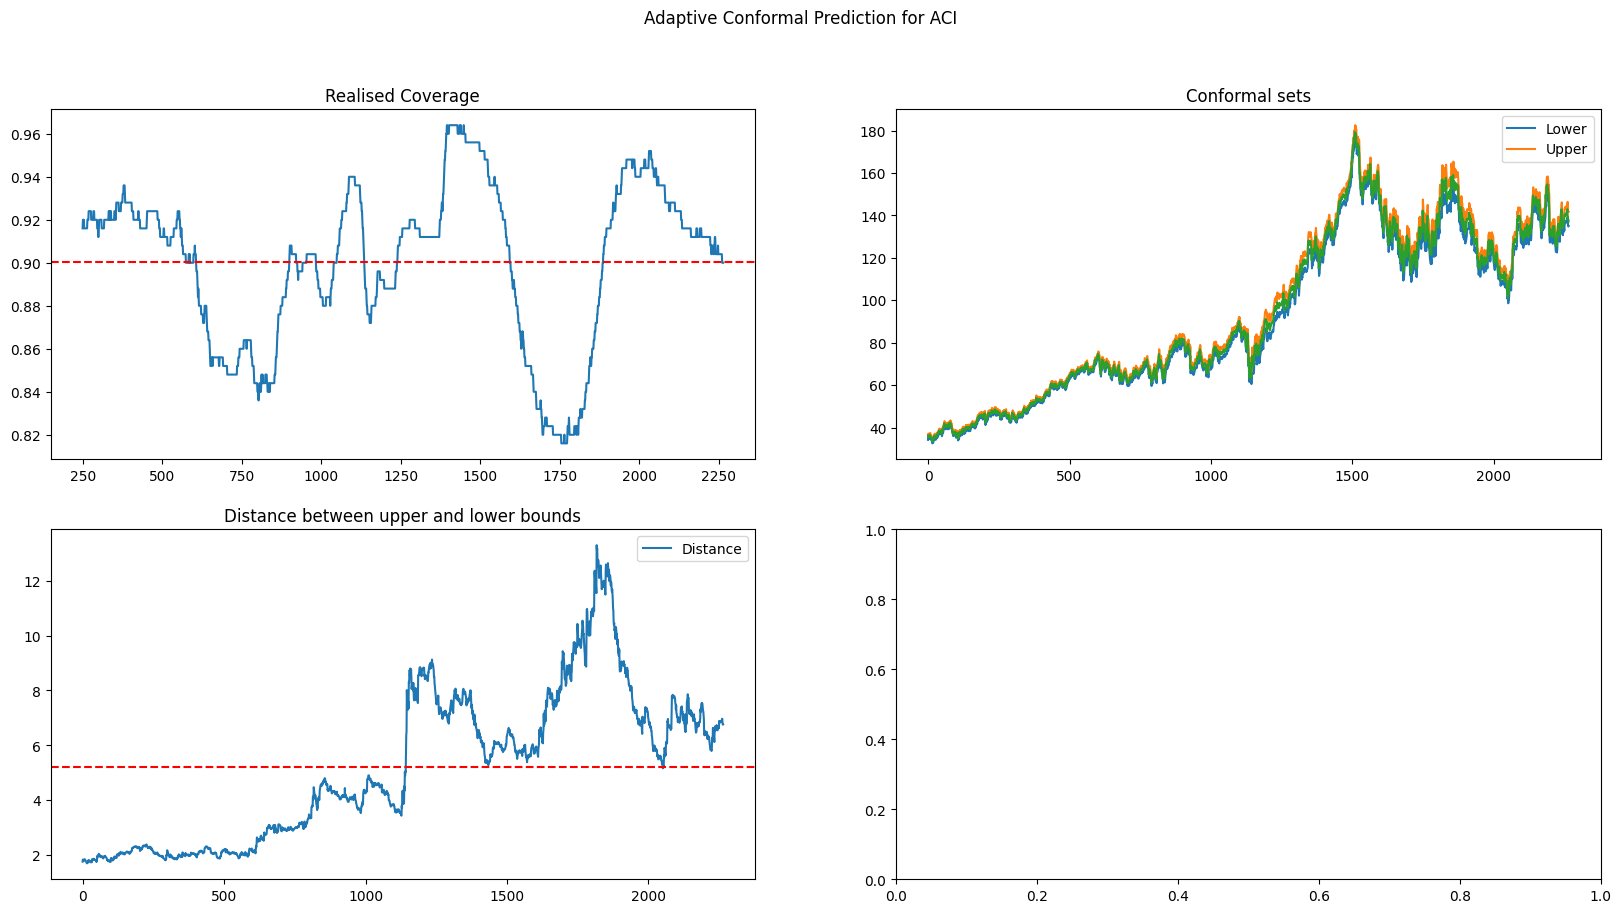

In [157]:
aci_result = instance.ACI(aci_data[0], 0.005)
ACP_plots.one_plot(aci_result, aci_data[0][1])

It is shocking in comparison

5.986622082703028 0.8913806451612903


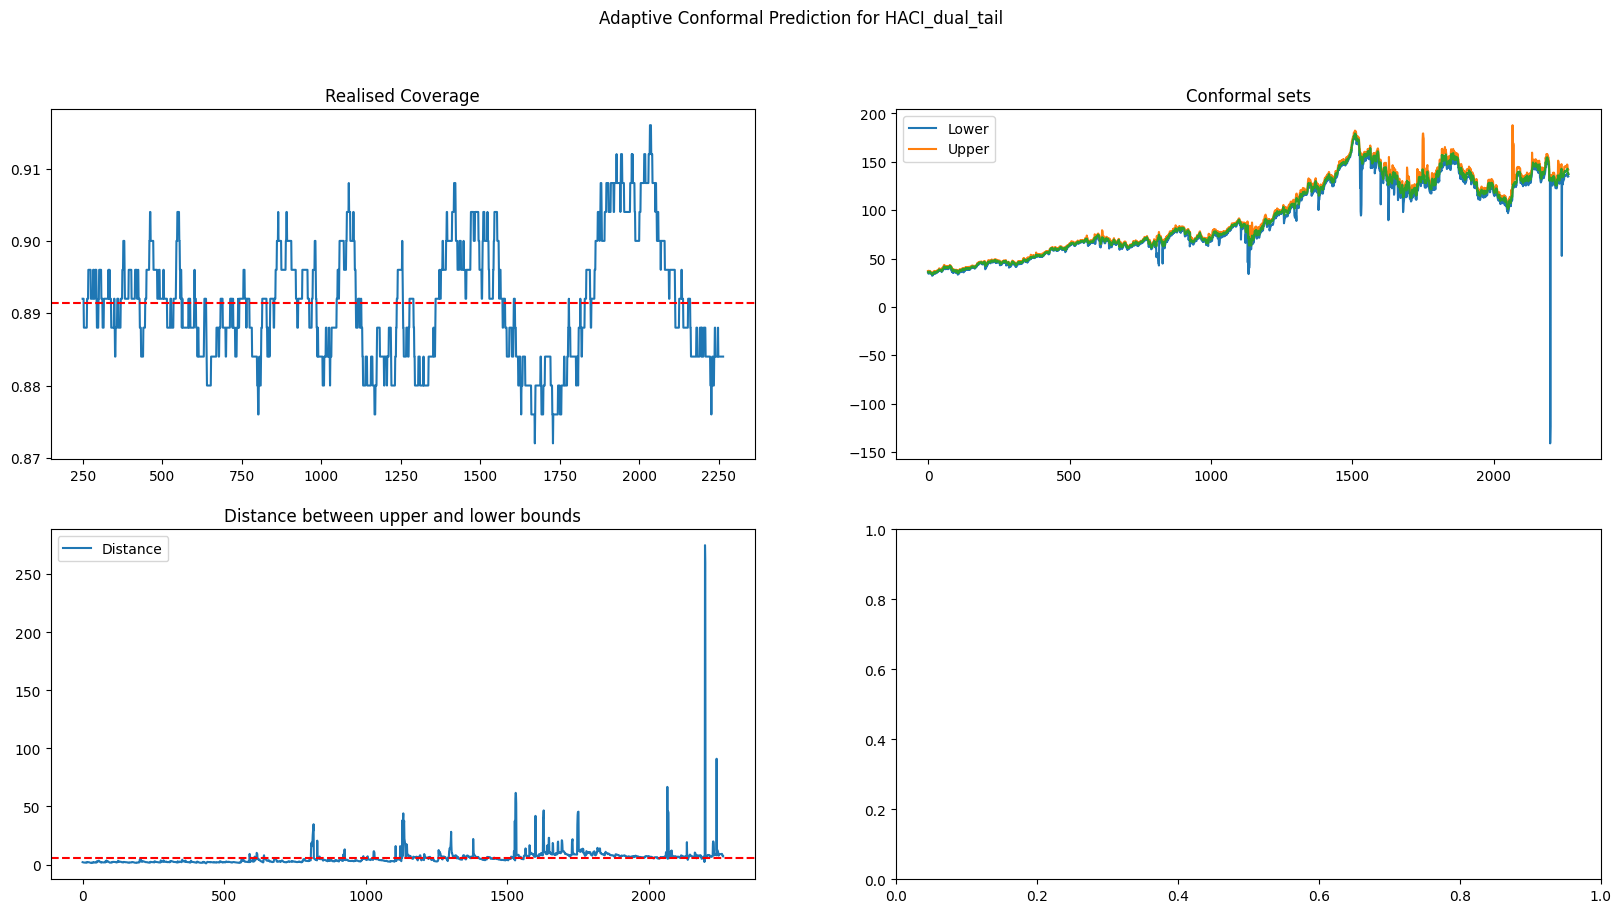

6.285459302120264 0.889887841191067


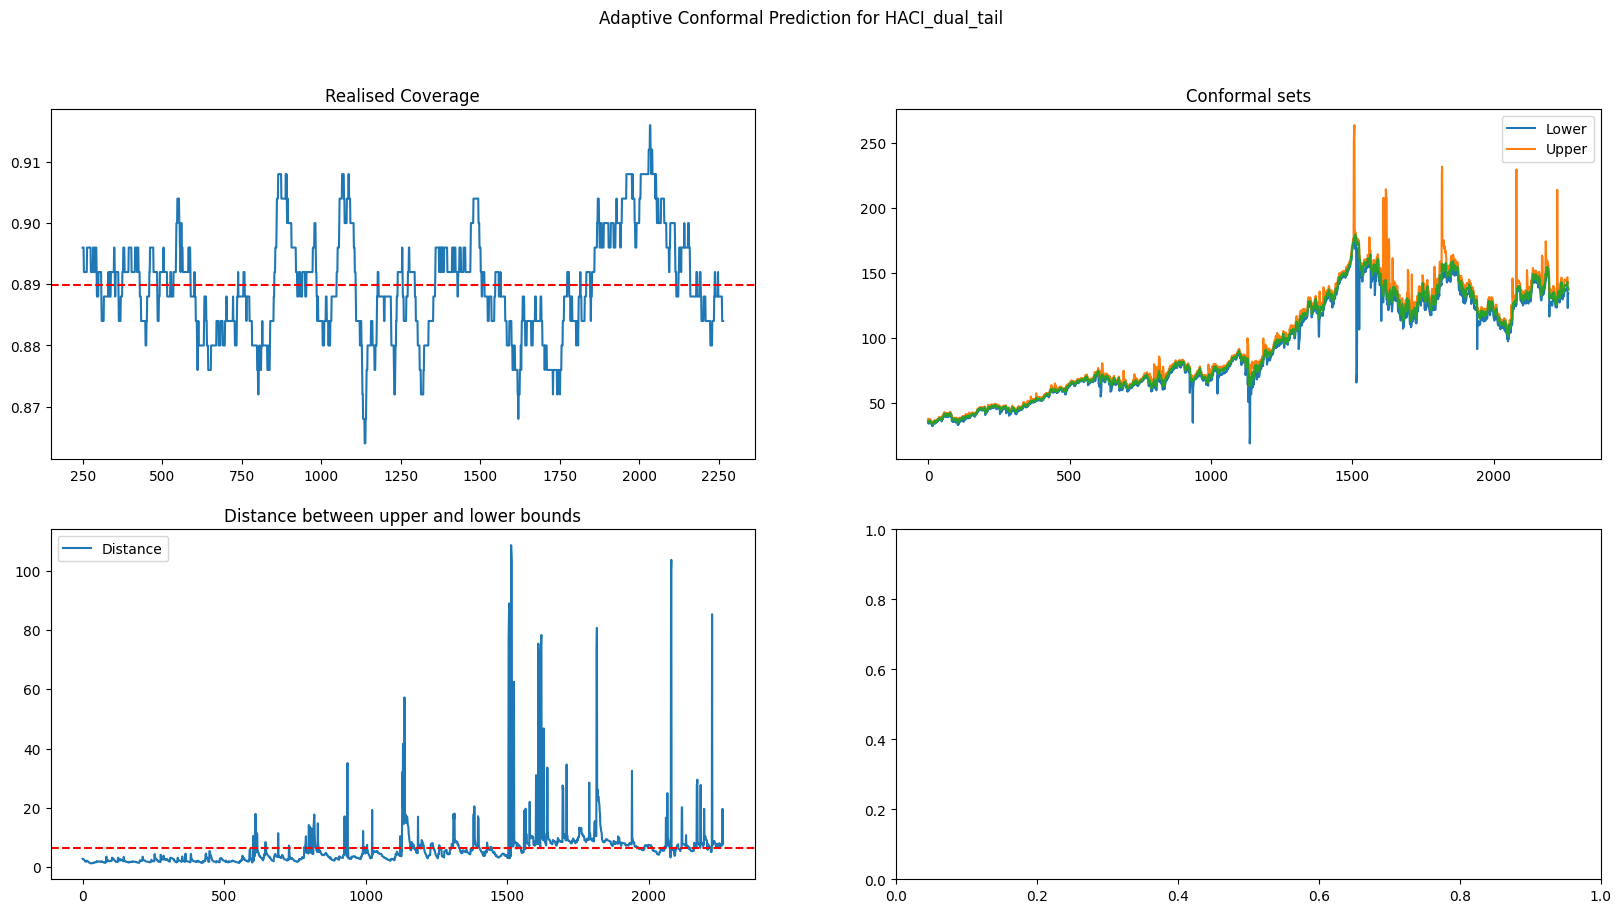

6.888181981801004 0.8894511166253102


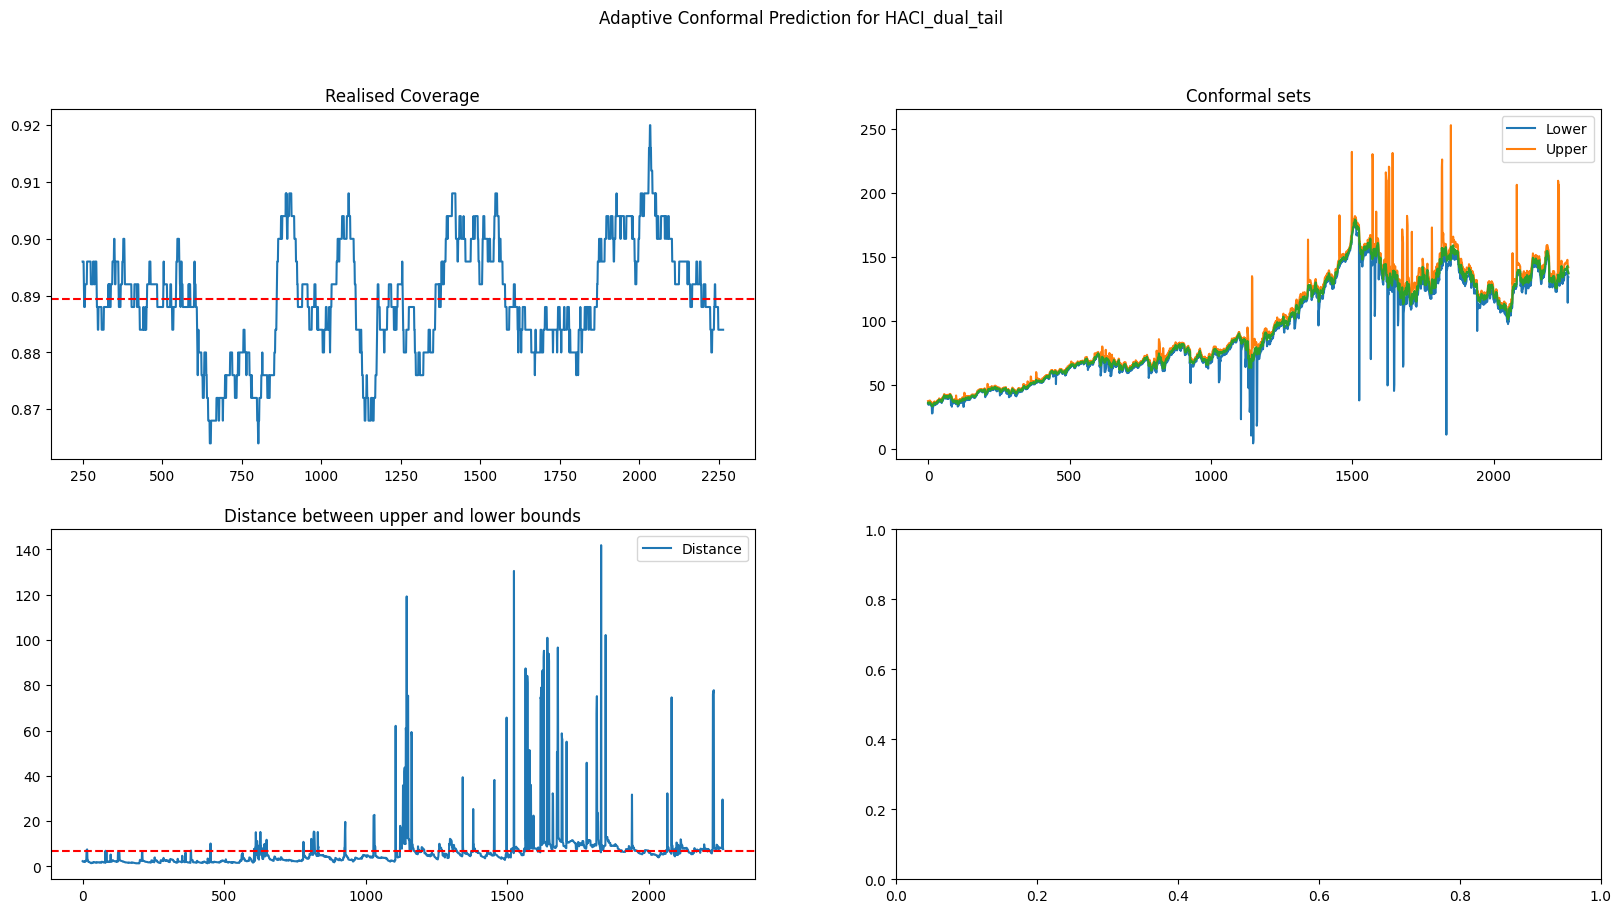

6.895553921542294 0.8900764267990074


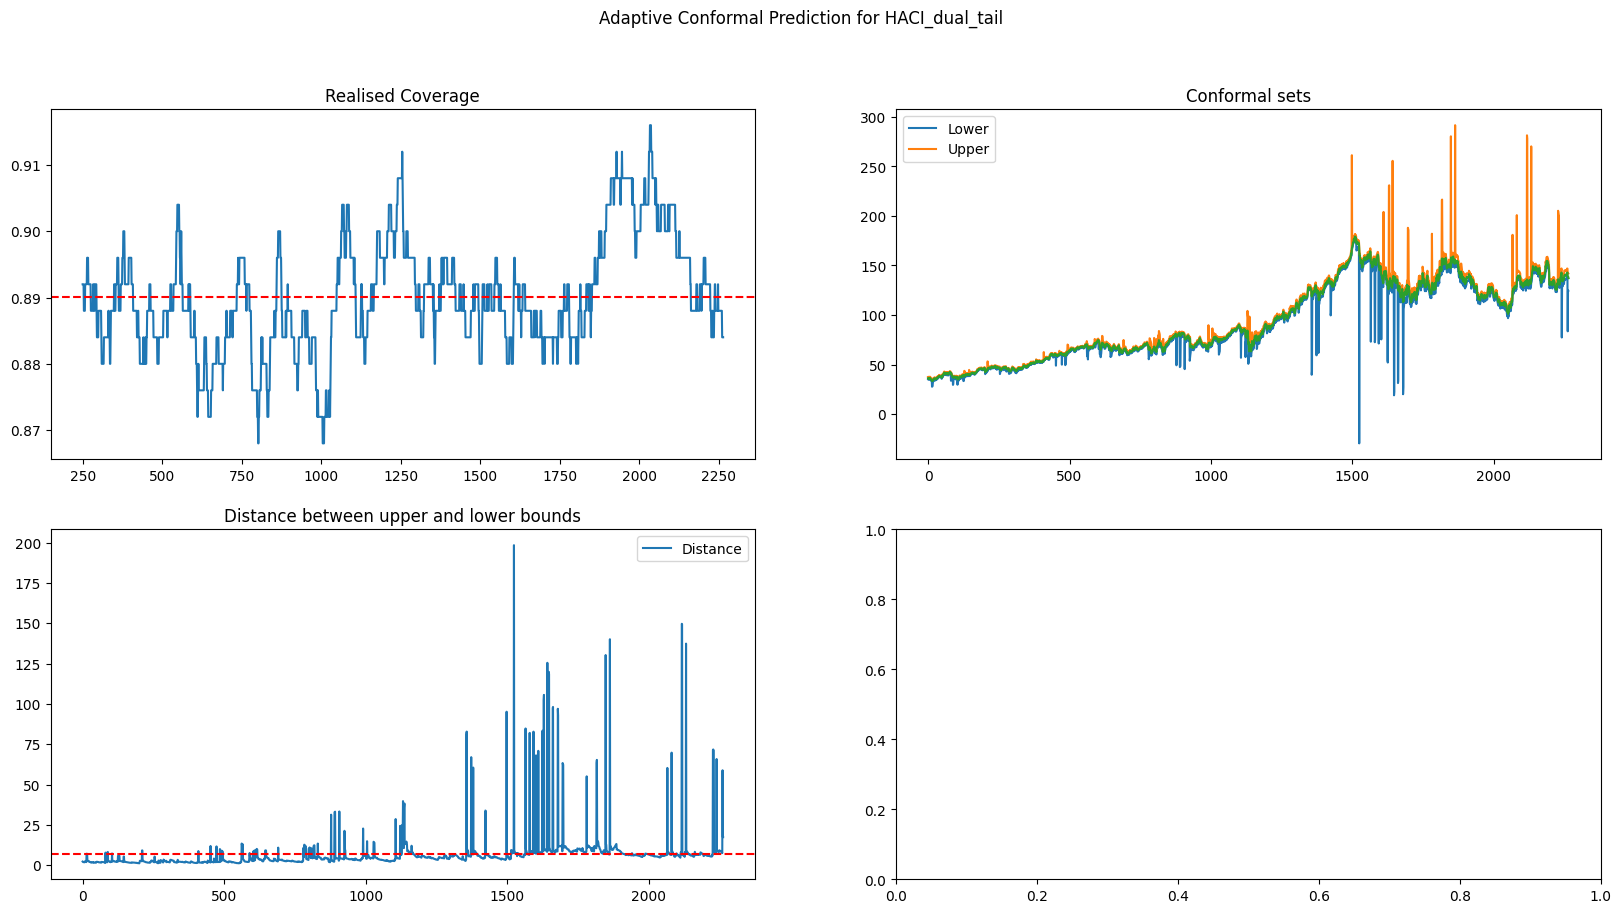

9.316296055866712 0.8877538461538461


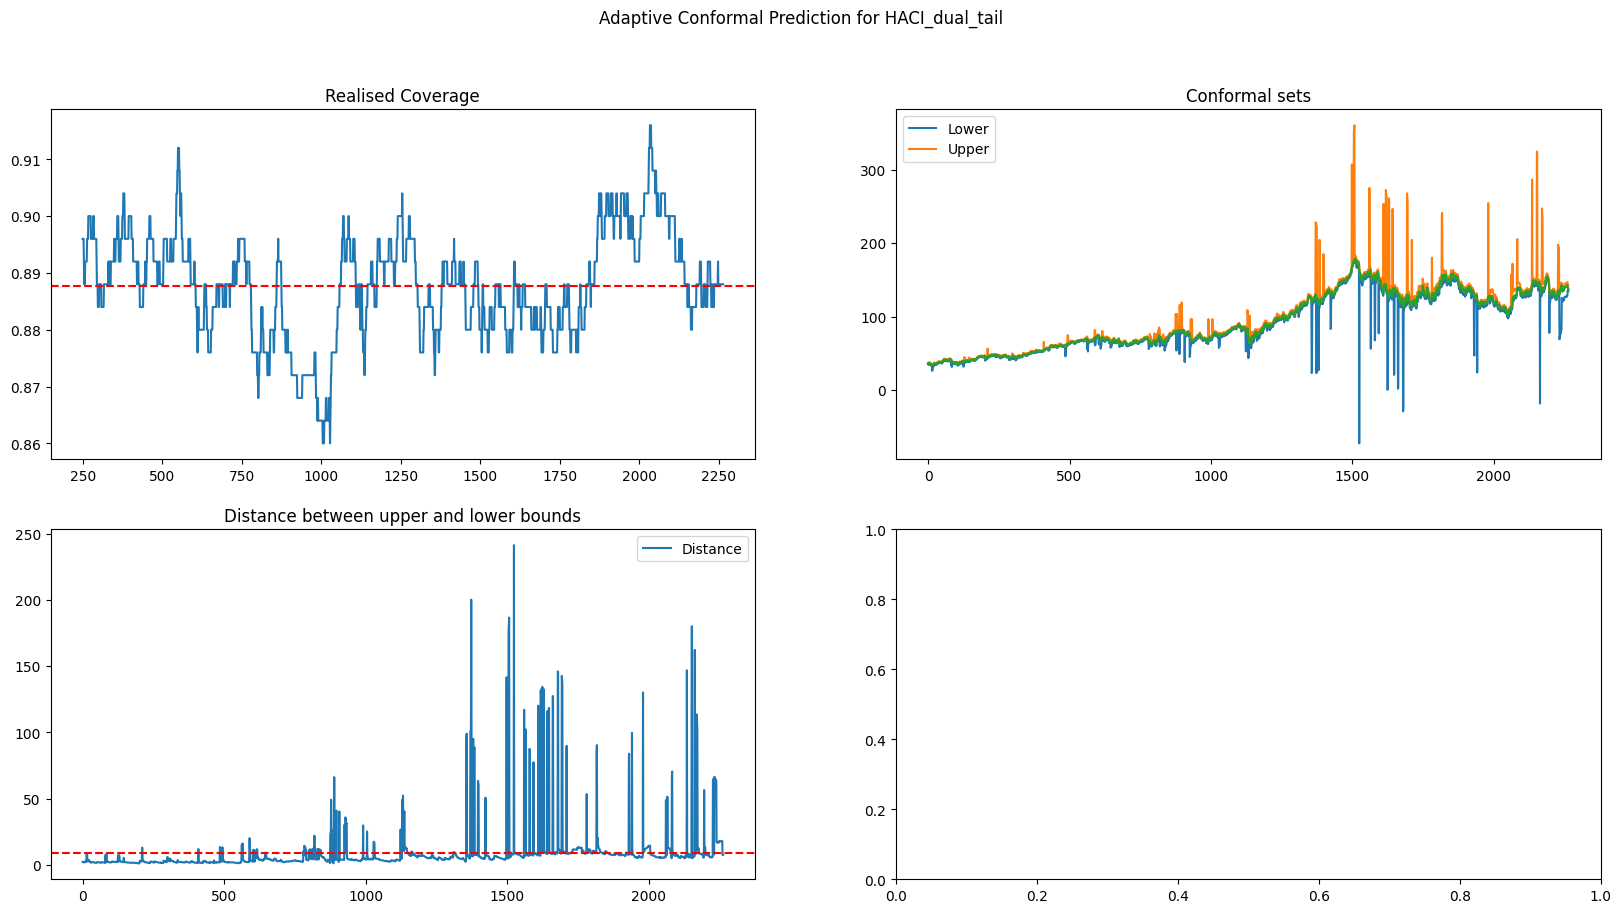

8.03155661647393 0.8897508684863523


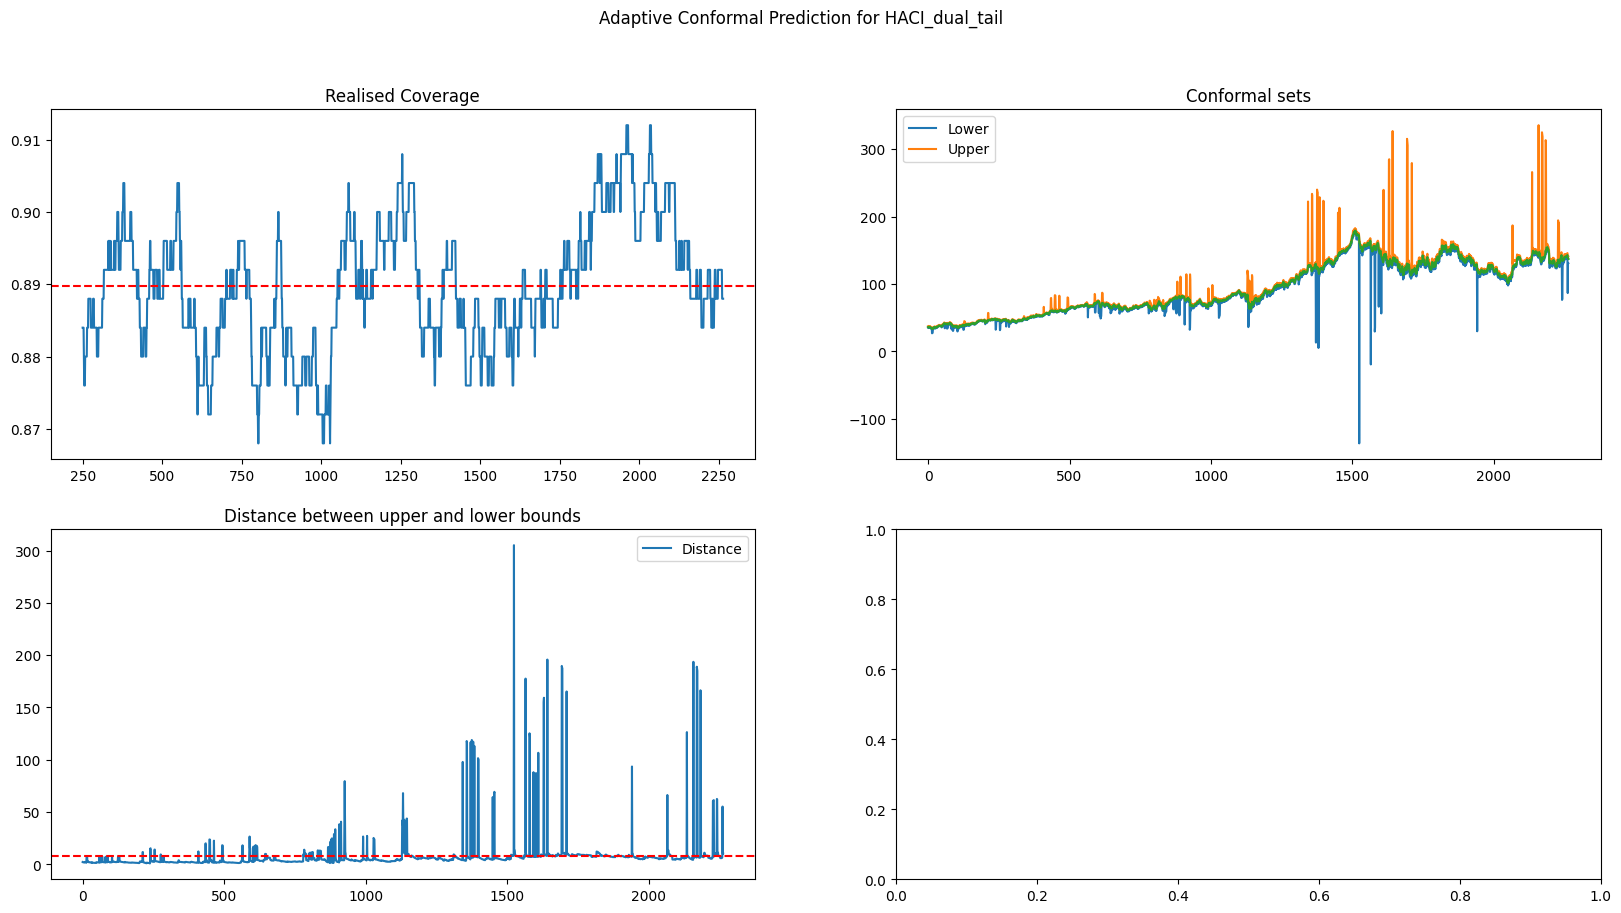

10.499299615107313 0.8890660049627792


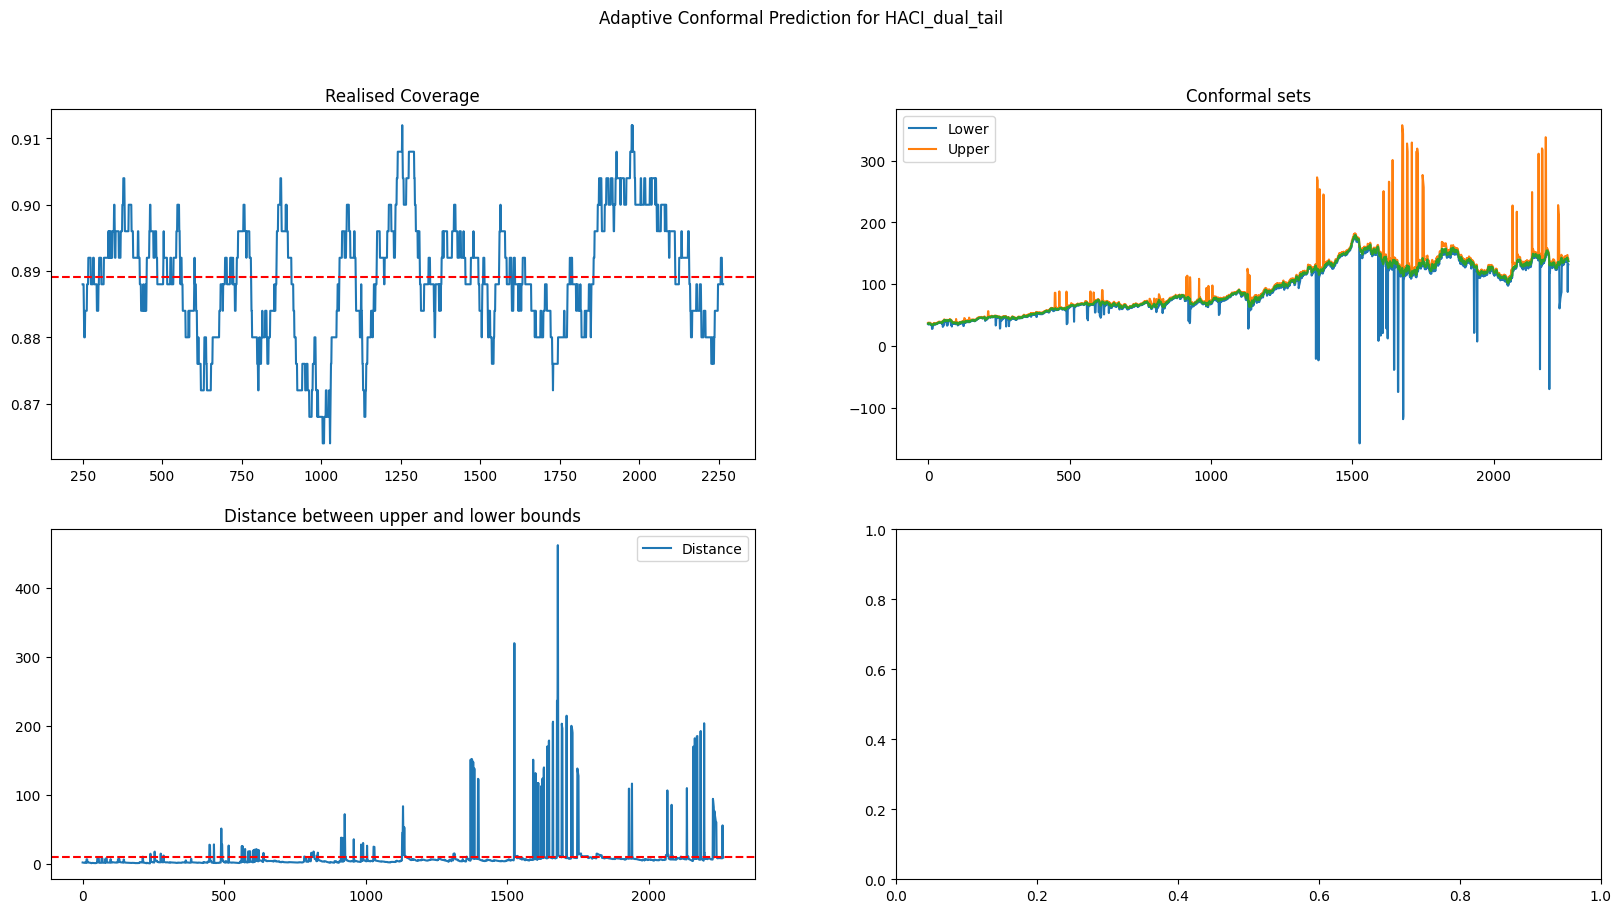

10.760540419054282 0.8887285359801489


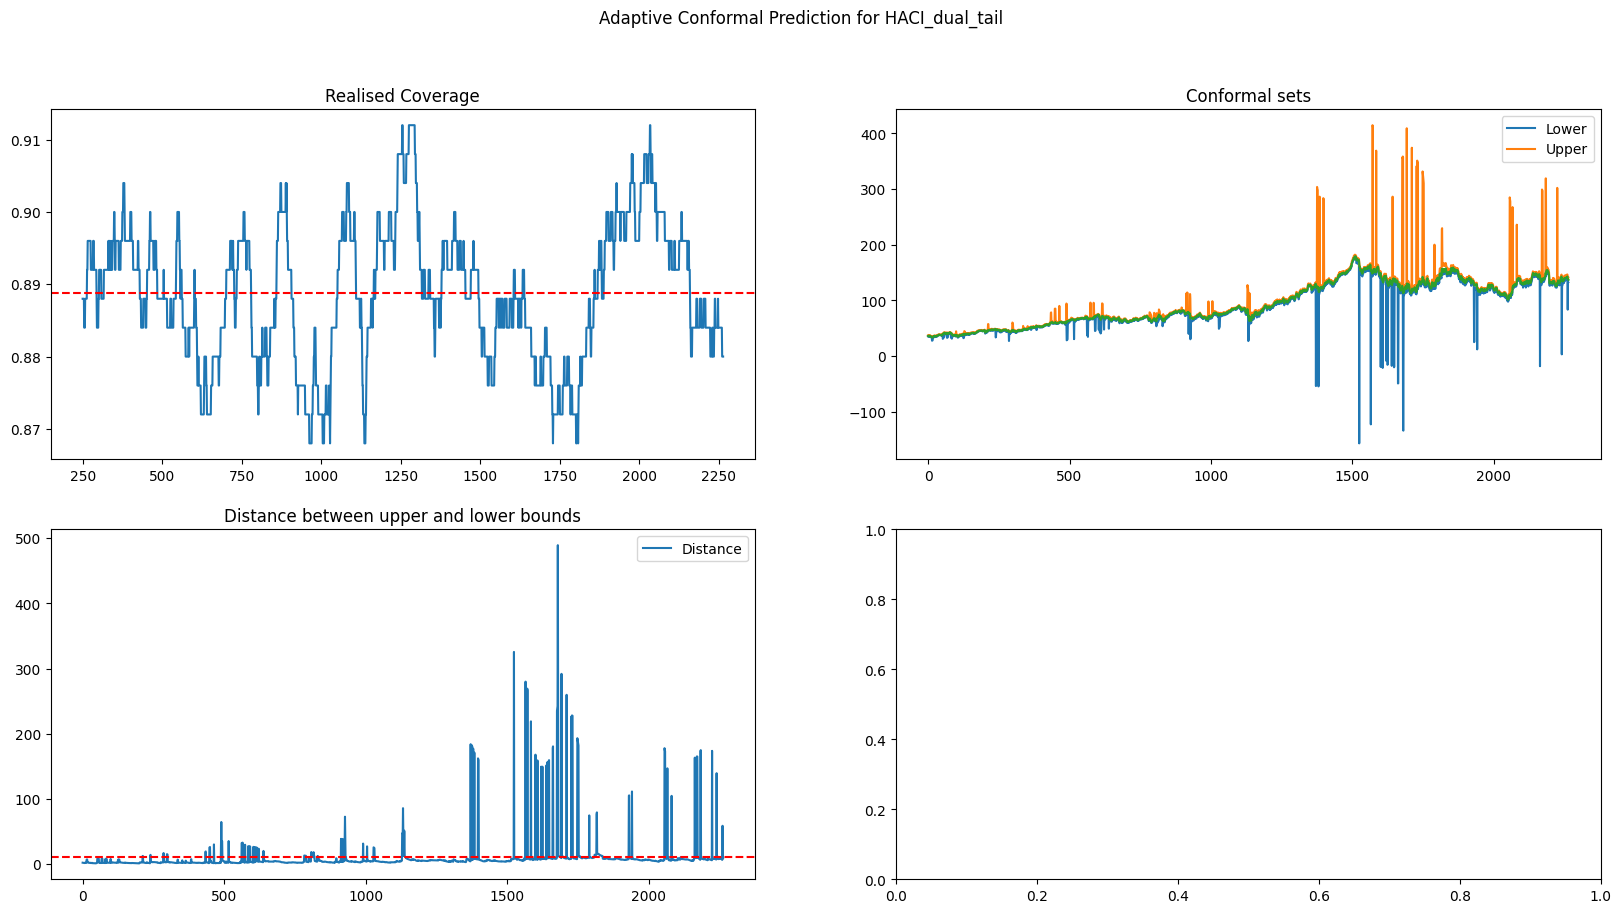

12.340168876361961 0.8869260545905707


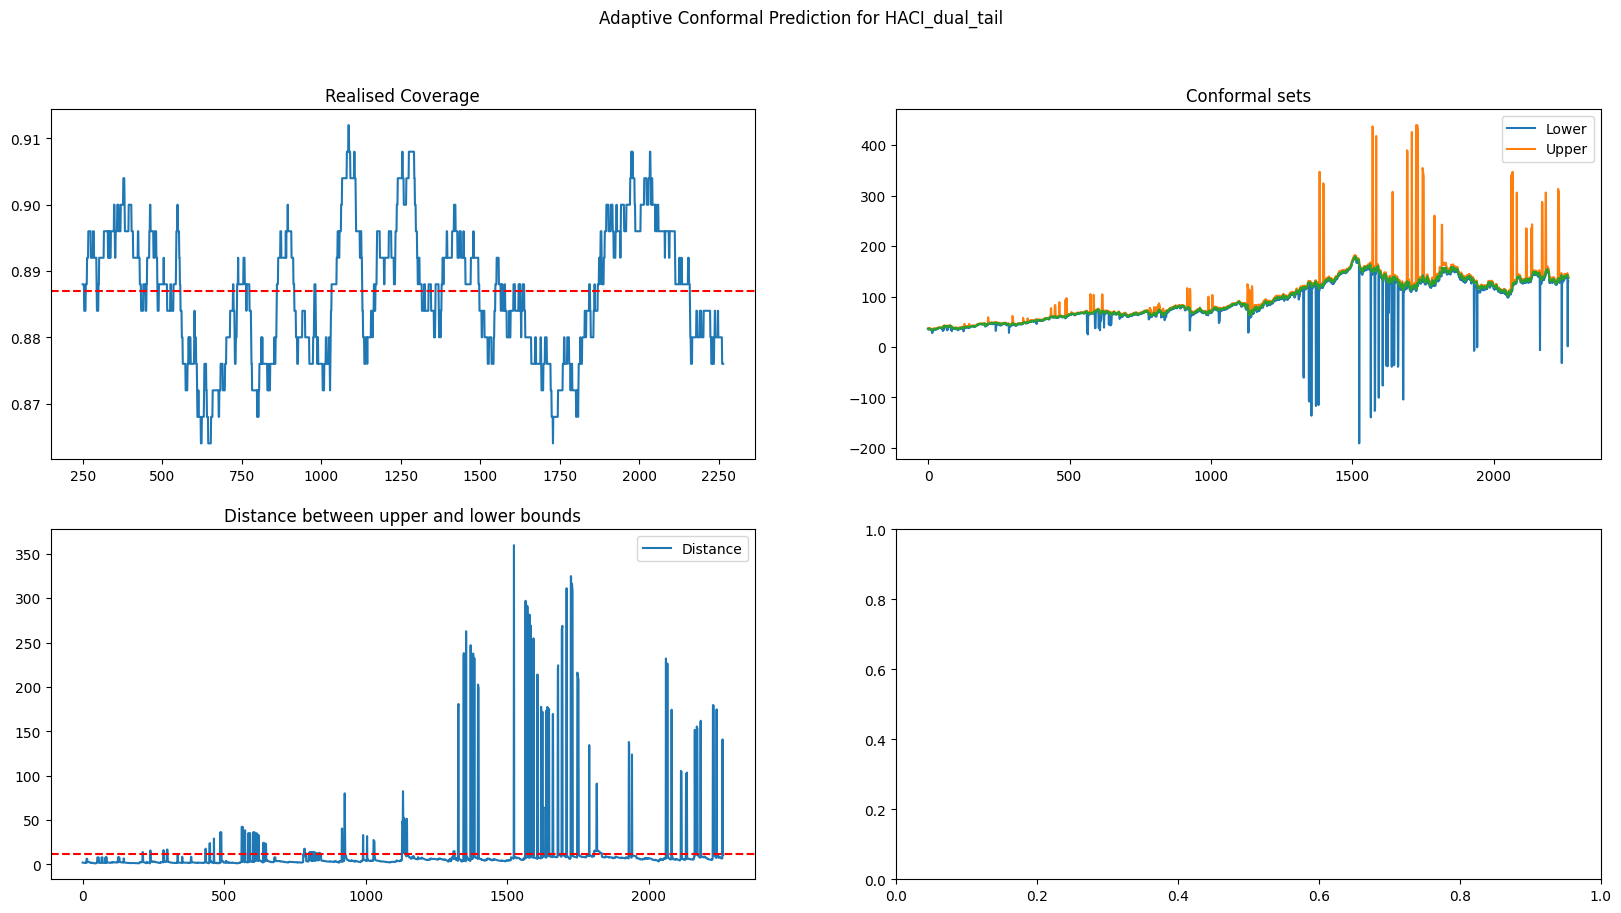

12.882908547539744 0.8880853598014888


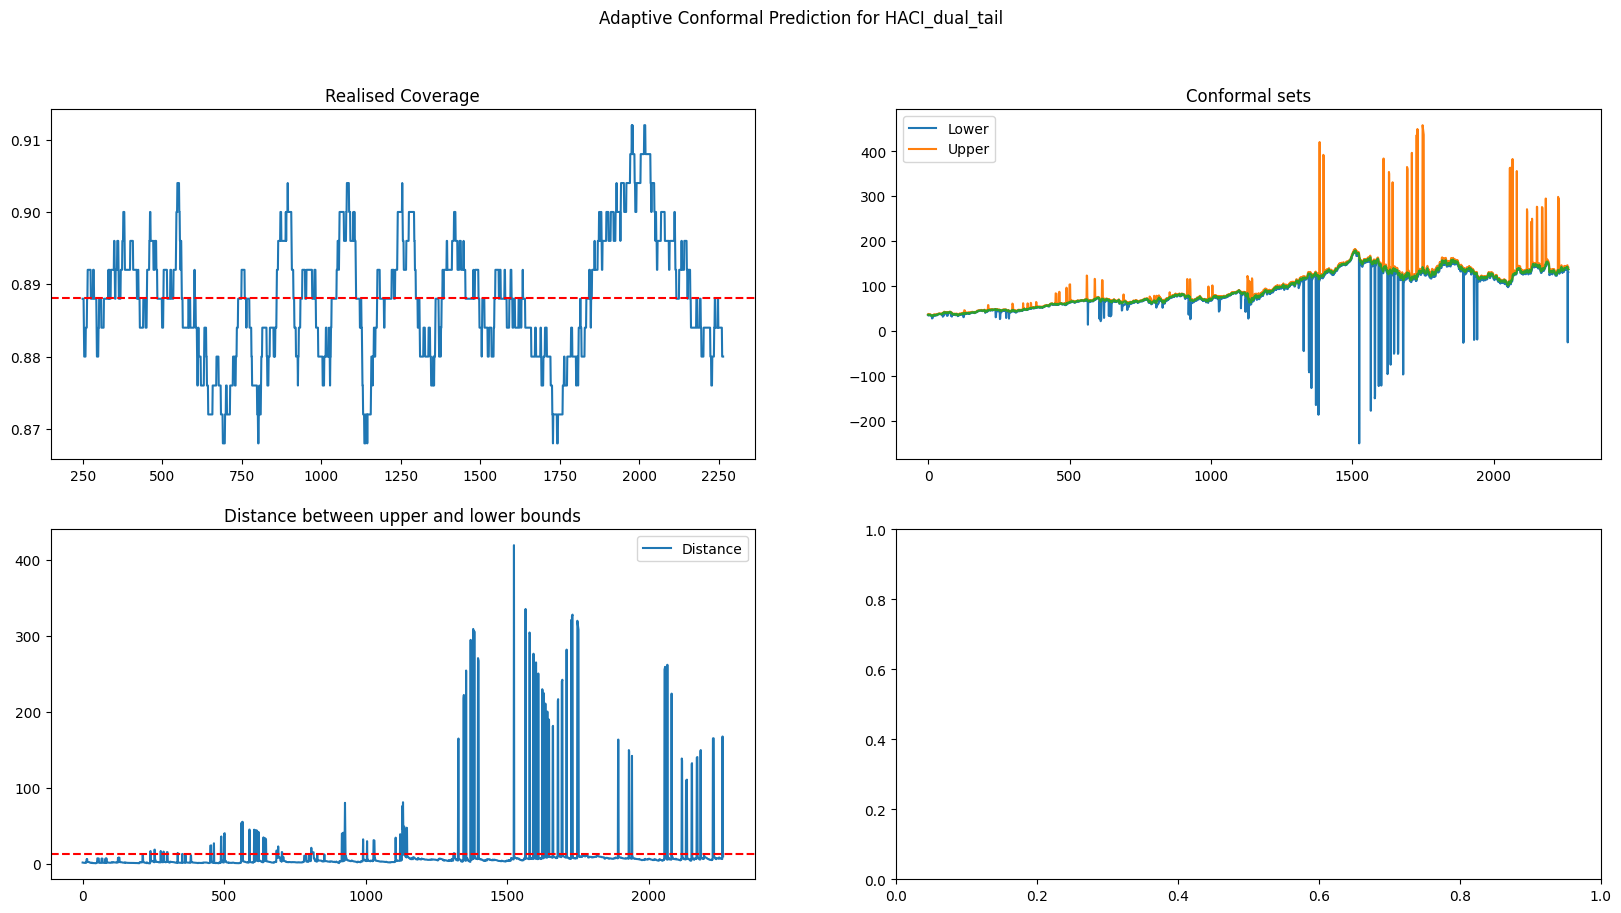

In [159]:
# Simple plot for each.
for key, item in model_error_raw_results.items():
   
    print(item['average_prediction_interval'], item['realised_interval_coverage'])
    ACP_plots.one_plot(item, aci_data[0][1])
    plt.show()

In general the smaller lookback seems analgous with a better result. 

If it it is true that a smaller lookback is a better volatility estimator then this is positive for the efficacy of the method.
- All these methods outperform HACI they are more adaptible, however they are consitently undercovering which is intresting. 

The smallest window seems to be the most adaptible, as it has more of a local volatility estimate. 

## Next steps.

Test with other variance models.

For instance GARCH.

WHat is this testing:
- The effects of a good variance model? I am already condident that a good variance model massivley improves.
- Why does having the variance improve the model?

In [161]:
print(model_error_raw_results[10]['params_t_list'])

{'lower': [(0, 0), array([-0.94103839, -0.20537712]), array([-0.94104897, -0.20533627]), array([-0.97484016, -0.0811121 ]), array([-0.97484015, -0.0811121 ]), array([-0.95260604, -0.10878909]), array([-0.95260604, -0.10878909]), array([-0.97675472,  0.13455921]), array([-0.96401015,  0.11842768]), array([-0.96465861,  0.12162595]), array([-0.96378543,  0.12179821]), array([-0.86902885,  0.15813686]), array([-0.86902885,  0.15813685]), array([-0.7966498 ,  0.09773251]), array([-0.79664979,  0.09773251]), array([-0.99464585, -0.10435882]), array([-0.99464584, -0.10435882]), array([-0.99464584, -0.10435882]), array([-0.99466879, -0.10427402]), array([-0.99466874, -0.10427395]), array([-0.97249441, -0.08403227]), array([-0.97249363, -0.08403305]), array([-0.91581933, -0.11925474]), array([-0.84470471, -0.09705128]), array([-0.84470481, -0.09705132]), array([-0.85546326, -0.05469847]), array([-0.81275424, -0.02680855]), array([-0.72751977, -0.11067473]), array([-0.72751979, -0.11067477]), a

In [178]:
import seaborn as sns

def plot_params(key:int):
    params = model_error_raw_results[key]['params_t_list']['lower']
    
    print(type(params))
    phi, beta = list(zip(*params))

    # Plot phi
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=range(len(phi)), y=phi)
    plt.xlabel('Time')
    plt.ylabel('Phi')
    plt.title(f'Phi for Model Error {key}')
    plt.show()

    # Plot beta
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=range(len(beta)), y=beta)
    plt.xlabel('Time')
    plt.ylabel('Beta')
    plt.title(f'Beta for Model Error {key}')
    plt.show()

<class 'list'>


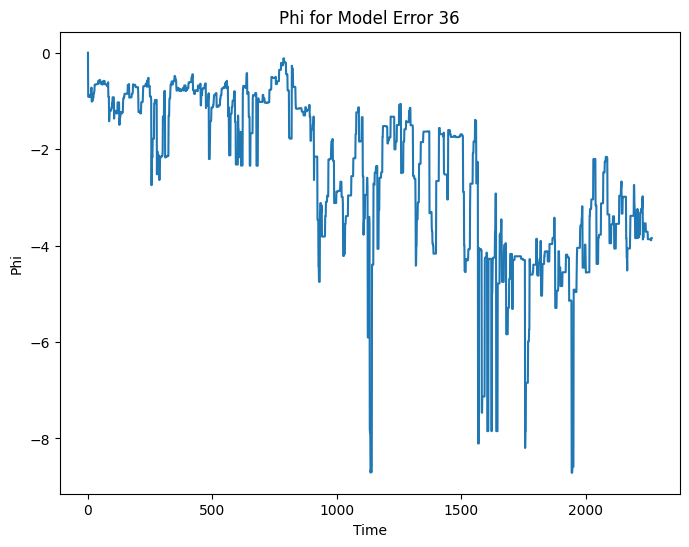

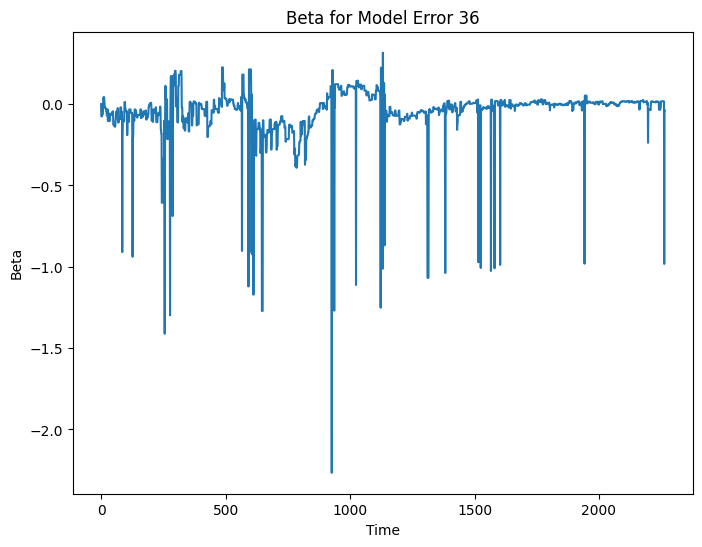

In [179]:
plot_params(36)

In [292]:
# Now I am going to plot the beta for differnt keys on the same plot. 

def compare_betas(keys_to_compare):
     # Plot phi
    plt.figure(figsize=(8, 6))

    for key in keys_to_compare:
        params = model_error_raw_results[key]['params_t_list']['lower']
        phi, beta = list(zip(*params))
        weight = pd.Series(model_error_data_dict[key][0][1][250:]).rolling(50).mean()
        
        phi_weight = pd.Series(phi).rolling(50).mean() 
        
        sns.lineplot(x=range(len(beta)), y= phi_weight, label = f'Average of phi: {key}')
        sns.lineplot(x=range(len(beta)), y=pd.Series(beta).rolling(50).mean() * weight, label=f'Model Error: {key}')
    
    plt.xlabel('Time')
    plt.ylabel('Phi')
    plt.title(f'Phi for Model Error {key}')
    plt.show()

In [293]:
print(lookback_array)

[ 10  36  63  90 116 143 170 196 223 250]


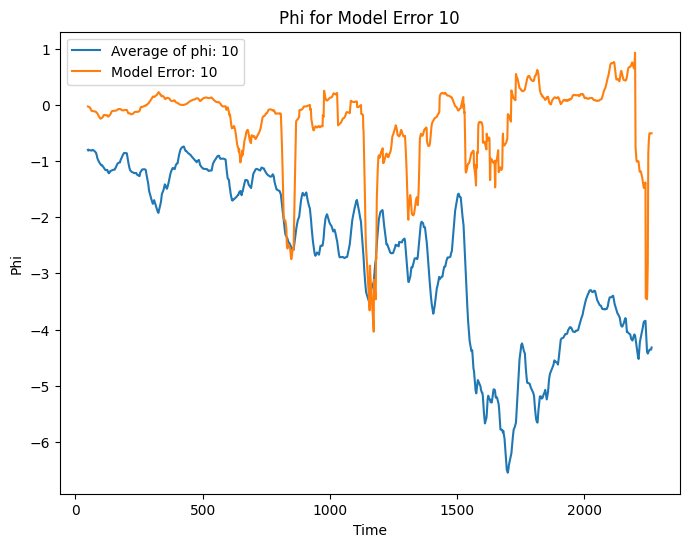

In [299]:
compare_betas([10])

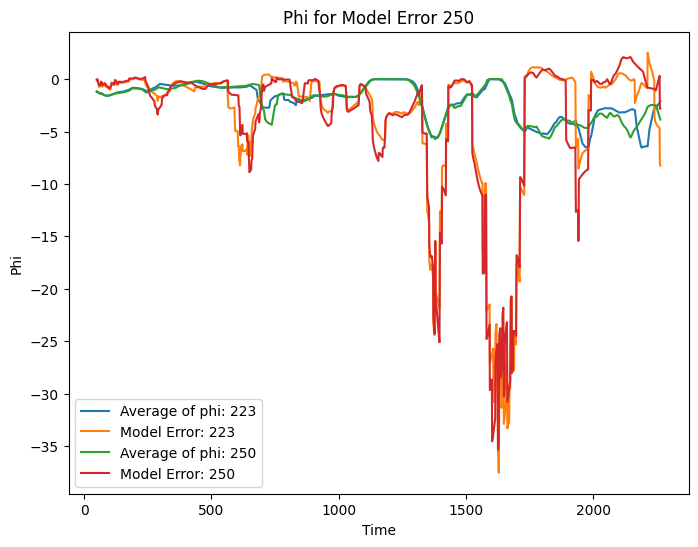

In [297]:
compare_betas([223, 250])

In [2]:
compare_betas([116, 143])

NameError: name 'compare_betas' is not defined

The above shows that the variances more or less are playing the same weight in the calculation of the score quantile. 
Except for the large lookbacks their are brief periods where it plays a larger part.


For the smaller lookback, the variance plays less of a determining factor then the on the larger lookbacks where the variance takes over. 

## Would be more sensible to just plot with parameters and not rolling. 

In [1]:
def compare_param_cotibution(keys_to_compare):
     # Plot phi
    plt.figure(figsize=(8, 6))

    for key in keys_to_compare:
        params = model_error_raw_results[key]['params_t_list']['lower']
        phi, beta = list(zip(*params))
        
        var = np.array(model_error_data_dict[key][0][1][250:])
        
        var_component = beta * var
        
        sns.lineplot(x=range(len(beta)), y= var_component, label = f'Var component {key}')
        sns.lineplot(x=range(len(beta)), y=phi, label=f'"Phi Component {key}')
    
    plt.xlabel('Time')
    plt.ylabel('Phi')
    plt.title(f'Phi for Model Error {key}')
    plt.show()

Now Im concerend that the variance is doing relativley little you need to see the average variance.

In [295]:
np.mean(model_error_data_dict[250][0][1])

92.31009176312989

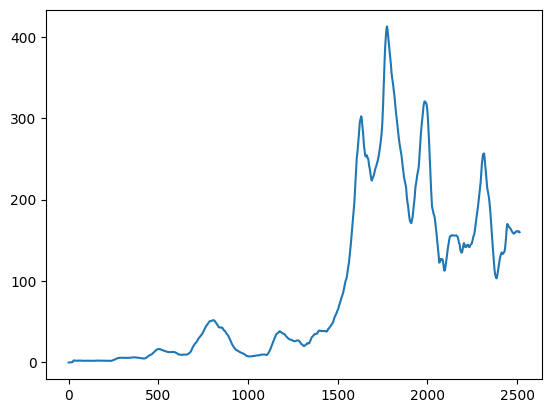

In [296]:
plt.plot(model_error_data_dict[250][0][1])
plt.show()

Variance is playing a factor.